<a href="https://www.kaggle.com/code/praoiticica/titanic-decision-trees?scriptVersionId=134997703" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic survival - Decision trees

# 1. Introduction

Given their transparency and relatively low computational cost, Decision Trees are also very useful for exploring your data before applying other algorithms. They're helpful for checking the quality of engineered features and identifying the most relevant ones by visualizing the resulting tree. The main downsides of decision Trees are their tendency to over-fit, their inability to grasp relationships between features (It is the job of on-supervised mapping algorithms…), and the use of greedy learning algorithms (not guaranteed to find the global optimal model). Using them in a Random Forest helps mitigate some of these issues. The Titanic dataset has two basic challenges, first, we need to perform a very hard cleaning and some features need to be engineered. The methods used in feature engineering will influence the final predictions with any ML algorithm. The more we dive into the Titanic dataset to clean it more we find interesting information hidden in the dirty not structured table columns. In this work, we explore the possibilities of the decision trees to fill in missing data in the Titanic dataset and to predict the survival probability of the passengers.
In the following sections, I performed the cleaning of the columns and feature engineering to prepare the variables to be suitable inputs to a decision tree model. We also perform feature engineering to obtain information hidden in the columns "Name", "Ticket" and others expanding the dimensional space of the dataset. We employed a decision tree algorithm to estimate the missing values of the engineered feature "Age_group". The cleaned and engineered titanic dataset was employed to build and train a decision tree classifier to predict the survival status of the passengers. We optimized the hyperparameters of the tree using cross-validation pre-pruning (with GridSearchCV from scikit-learn) and also post-pruning by plotting the cross-validate accuracy with the ccp_alpha values and visualizing the point where the tree starts to overfit. We obtained test accuracy values between 0.78 for the test_data and 0.83 for the train accuracy score.
Decision trees are simple learners, it is not suitable for hard predicting jobs, but it helps a lot in the visualization of the feature importance and the inter-relationships between them to predict a given target variable.

In [53]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib widget
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import chart_studio.tools as tls

# username = 'your_username'  # Replace with your Chart Studio username
# api_key = 'your_api_key'  # Replace with your Chart Studio API key

# # Set up authentication credentials
# tls.set_credentials_file(username=username, api_key=api_key)


from ipywidgets import interact

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

------------------

# 2. Load and explore the data

In [2]:
# Load the data
train = pd.read_csv("titanic_datasets/train.csv")
test = pd.read_csv("titanic_datasets/test.csv")
# concatenate train and test in same dataframe to perform data cleaning and feature engineering n both parts.
df = pd.concat([train, test], ignore_index = True, sort = False)
train_idx = df['Survived'].notnull()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.1 Exploratory data analysis

We make a simple EDA here to:

* Check the missing values and data types
* Make Barplots for some variables couting the survived and non survived.
* Make Heatmap correlation plots to see the inter-relationships between the variables and between the "Survived" and the other variables.

In [3]:
nan_counts = df.isna().sum().sort_values(ascending = False)
summary = pd.concat([df.info(), nan_counts], axis=0)
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
d

------------------------

# 3. Cleaning and feature engineering the dataset

The Titanic dataset contains missing values and incomplete columns. There are rows that contain more than one value per column as we can see in the column "Cabin" which contains more than one cabin per person. The column "Name" contains the name and title. The variable "Ticket" contains a prefix and a number. Some passengers have the same Ticket code. The columns "SibSp" (Siblings and Spouses) and the column "Parch", gives information about the number of family members aboard and the family structure but it would be better if the number of siblings info wasn't mixed with the number of spouses info, in the same way, the variable "Parch" mix info about children and parents. The passenger names (without the title) and the variable "Embarked" city may not contribute to the prediction. the variable "PassengerId" will be kept to compose the submission prediction table at the end for a Kaggle submission.
A good approach is to perform cleaning and engineer some features before applying rules to fill the NaN values. We can create the feature "Title" by extracting from the column "Name" the titles: Mr. Miss. Mrs. Dr. and others. (see also Sina ["Tinatic best working classifier"](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier)). This idea can be applied also to extract information on the Ticket prefix. Maybe this prefix tells something about the status of the passenger (maybe not). The Cabin information can be very informative as the distance from the boat deck where the lifeboats were located may influence the chance of survival. Although, this column is not structured and has mostly missing values. To solve this we can try to split this column into three columns: ['Cabine_label', 'Cabine_number', 'N_of_Cabins reserved'] it is the best we can do for the column "Cabin". It is not easy to find criteria to fill missing values (NaN) and sometimes the work is too hard but in the end, this variable can be discarded by the model due to inefficacy in predicting the survival probability. The variable Age will be categorized into ranges and we will employ a simple decision tree with the other variables to help fill in the missing data about the Age. It is impossible to predict the exact Age of the passenger but we can try to predict the Age_group. The excellent aspect of the decision trees is that we don't have to worry about the feature importance because the algorithm will rank it for us and we can visualize the learned and acquire information about the feature importance.
In the next sections, we will perform cleaning and feature engineering on the Titanic dataset so we can apply more sophisticated exploratory data analysis and employ it to train and test an ML model.

* Map "Sex" to "Sex_bool".
* Map 'Embarqued' to Embarqued_code{1,2,3}. reserve the zero for NaN.
* Split the variable "Ticket" into "Ticket_preffix" and "Ticket_n"
* Group the duplicated Ticket values and count the number of people that travels together including friends, maids, and nannies and create the variable "Companions".
* Create the variable "FamilySize" by combining the variables "SibSp" and "Parch".
* Extract the variable "Title" from the variable "Name" and categorize.
* Map "Fare" to "Fare_level": {1,2,3,4,5,6,7,8,9,10}
* The dirtiest variable 'Cabin' -> split it into ['Cabin_label', 'Cabin_n', 'n_of_Cabins'].
* Engineer the variable Age_group and predict the missing values using an ML decision tree model trained with the non-missing entries.

## 3.1 Sex

Encode the Variable "Sex" to "Sex_bool", 0 for famale, 1 for male.

In [4]:
# Mapping Sex bolean
df['Sex_bool'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

## 3.2 Embarked

Clean the variable for the port of embarkation, "Embarked". First, we fill only two NaN values with the true value we found on Google, then encode the variable to numerical values. The values C = Cherbourg, Q = Queenstown, and S = Southampton, will be mapped to 1 = C, 2 = Q, and 3 = S.

In [5]:
# Check the entries with NaN vales.
df.loc[df['Embarked'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bool
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


We see both passengers share the variable values, Sex = female, Pclass = 1, they were in the same Cabin = B28, and the Ticket number is the same Ticket = 113572. Do you think it is a coincidence? I think Not! If we try to see the number of passengers with these characteristics will guess the Embarked being either C or S. Alternatively we can google search for it and find that: Mrs. Stone boarded the Titanic in Southampton on 10 April 1912 and was traveling in first class with her maid Amelie Icard. She occupied cabin B-28.([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html))

In [6]:
# filter and count the most frequent values
df.loc[(df['Sex'] == 'female') & (df['Pclass'] == 1), 'Embarked'].value_counts(dropna= False)

Embarked
C      71
S      69
NaN     2
Q       2
Name: count, dtype: int64

In [7]:
# Fill the NaN and map Embarked to numerical codes
df.loc[df['Embarked'].isna(), 'Embarked'] = 'S'  # (Encyclopedia titanica)
df['Embarked_code'] = df['Embarked'].map( {'C': 1, 'Q': 2, 'S': 3} ).astype(int)

## 3.3 Ticket

Split the "Ticket" into the variables "Ticket_preffi" and "Ticket_number"

In [8]:
# split the column 'Ticket'
Ticket_split = []
Ticket_len = []
for i in df['Ticket'].index:
    splitted = df.loc[i,'Ticket'].split(' ')
    Ticket_split.append(splitted)
    length = len(splitted)
    Ticket_len.append(length)
    
df['Ticket_split'] = Ticket_split
df['Ticket_len'] = Ticket_len

# df[['Ticket_len']].value_counts()
# df.loc[df['Ticket_len'] > 2, :] We can see tome typo errors.

# Create columns Ticket_preffix and Ticket_number
ticket_preffix = []
ticket_number = []
for i in df['Ticket'].index:
    ticket_parts = df.loc[i, 'Ticket_split']
    number = ticket_parts[-1]
    ticket_number.append(number)
    length = df.loc[i, 'Ticket_len'].item()
    if length > 1:
        preffix = ''.join(ticket_parts[0:-1])
        ticket_preffix.append(preffix)
    else:
        ticket_preffix.append('blanck')
        
df['Ticket_preffix'] = ticket_preffix
df['Ticket_number'] = ticket_number
# drop unnecessary columns created
df.drop(columns=['Ticket_split', 'Ticket_len'], inplace=True)

df.Ticket_preffix.unique()

array(['A/5', 'PC', 'STON/O2.', 'blanck', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON', 'SC/A.3', 'STON/OQ.', 'SC/A4', 'AQ/4',
       'A.2.', 'LP', 'AQ/3.'], dtype=object)

In [9]:
df_grouped = df.groupby(['Ticket_preffix', 'Embarked']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Ticket_preffix', 'Embarked']).size()
print(df_grouped)

                         Survived  Non-Survived  Count
Ticket_preffix Embarked                               
A./5.          S              0.0           2.0      3
A.2.           S              0.0           0.0      1
A.5.           S              0.0           2.0      3
A/4            S              0.0           3.0      6
A/4.           S              0.0           3.0      3
A/5            S              1.0           9.0     12
A/5.           Q              0.0           1.0      1
               S              1.0           5.0      9
A/S            S              0.0           1.0      1
A4.            S              0.0           1.0      1
AQ/3.          Q              0.0           0.0      1
AQ/4           Q              0.0           0.0      1
C              S              2.0           3.0      8
C.A.           C              0.0           0.0      1
               S             13.0          14.0     45
C.A./SOTON     S              0.0           1.0      1
CA        

The column "Tiket_prefix" has some typo errors and seems to be related to the 'Embarked' info. Most of the values are blank and maybe it doesn't worth analyzing the survival probability.
Moreover, we already observed that the variable "Ticket_number" has some duplicated entries. Some passengers share the ticket number because they are together. They can have a relationship with an employee or service like a maid or a nanny, or they can be close friends. These relationships were not all captured in the variables "SibSp" and "Parch". See, for example, the case of Mrs. Stone boarded that was traveling with her maid Amelie Icard and both survived.([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)).

In the following line, we start to do some feature engineering. We extract implicit information and create a new variable to describe it. Let us add this information to the column "Companions" describing the number of companions or fellow passengers for each individual. Maybe this number makes some impact on the survival probability. 

In [10]:
df['Ticket'].shape

(1309,)

In [11]:
n_alone , n_duplicates = df['Ticket'].duplicated(keep=False).astype(int).value_counts()

print("Number of duplicated ticket values:", n_duplicates)
print("Number of non-duplicated ticket values:", n_alone)

Number of duplicated ticket values: 596
Number of non-duplicated ticket values: 713


We can check the distribution of the number of companions.

In [12]:
df['Companions'] = df['Ticket'].duplicated(keep=False).astype(int) * df.groupby('Ticket')['Ticket'].transform('count') -1 
df.loc[df['Companions'] == -1, 'Companions'] = 0
df['Companions'].value_counts()

Companions
0     713
1     264
2     147
3      64
4      35
6      35
5      24
7      16
10     11
Name: count, dtype: int64

## 3.4 Family size as a sum of SibSp and Parch

This is a feature engineering step as we are creating a new feature by combining two existing ones. The variables SibSp and Parch describe the family structure aboard for each passenger. However, the specific level of parental relationships may not be important; only the total number of family members may matter. In this case, these variables are redundant.

In [13]:
df['FamilySize'] = df['SibSp'] + df['Parch']
print(df[['SibSp','Parch','FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by = 'Survived'))

   FamilySize     SibSp     Parch  Survived
7           7  4.000000  3.000000  0.000000
8          10  6.727273  3.272727  0.000000
5           5  2.800000  2.200000  0.136364
4           4  2.000000  2.000000  0.200000
0           0  0.000000  0.000000  0.303538
6           6  3.250000  2.750000  0.333333
1           1  0.778723  0.221277  0.552795
2           2  0.893082  1.106918  0.578431
3           3  1.302326  1.697674  0.724138


## 3.5 The "Name" and corresponding "Title"

Now we will extract the passenger title information from the variable "Name". We can create the feature "Title" by extracting from the column "Name" the titles: Mr. Miss. Mrs. Dr. and others.(see also [Sina "Tinatic best working classifier"](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier)). 

In [14]:
# get the 'Title'
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

df['Title'] = df['Name'].apply(get_title)

df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
print(df_grouped)

                 Survived  Non-Survived  Count
Title    Sex                                  
Capt     male         0.0           1.0      1
Col      male         1.0           1.0      4
Countess female       1.0           0.0      1
Don      male         0.0           1.0      1
Dona     female       0.0           0.0      1
Dr       female       1.0           0.0      1
         male         2.0           4.0      7
Jonkheer male         0.0           1.0      1
Lady     female       1.0           0.0      1
Major    male         1.0           1.0      2
Master   male        23.0          17.0     61
Miss     female     127.0          55.0    260
Mlle     female       2.0           0.0      2
Mme      female       1.0           0.0      1
Mr       male        81.0         436.0    757
Mrs      female      99.0          26.0    197
Ms       female       1.0           0.0      2
Rev      male         0.0           6.0      8
Sir      male         1.0           0.0      1


clean and categorize the variable "Title", then check the counts of survived and non-survived for each categorized title.

In [15]:
# Clean the varianle Title.
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'noble')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Mrs')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Check the survival rate for the title cathegories obtained
df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
# Calculate the survived/non-survived rate
df_grouped['Survival Rate'] = df_grouped['Survived'] / (df_grouped['Survived'] + df_grouped['Non-Survived'])
# Order the DataFrame by the survival rate in descending order
df_grouped = df_grouped.sort_values('Survival Rate', ascending=False)

print(df_grouped)

               Survived  Non-Survived  Count  Survival Rate
Title  Sex                                                 
noble  female       3.0           0.0      4       1.000000
Mrs    female     101.0          26.0    200       0.795276
Miss   female     129.0          55.0    262       0.701087
Master male        23.0          17.0     61       0.575000
noble  male         5.0          15.0     25       0.250000
Mr     male        81.0         436.0    757       0.156673


We can see that being a noble made a very difference in the Titanic. The other titles reflect the sex and age of the passenger. We can observe that the survival rate for a man with the title master is better than those with the title Mr, although, it can be interpreted by age whereas younger man has a better chance to survive. If we compare the survival rate of women, the passengers with the title Miss. have a lower survival chance when compared to the women with the title Mrs. whereas it can indicate the status of the woman as married or not can make a difference. But we all agree that the information about the family and the age has its own features to describe. The exclusive information we can obtain from the title feature is if the passenger owns a noble title or not.

In [16]:
df['noble'] = df['Title'].apply(lambda x: 1  if x =='noble'  else 0)
df['noble'].value_counts()

noble
0    1280
1      29
Name: count, dtype: int64

## 3.6 Fare

We can substitute the "Fare" missing value (there is only one) with the median value. To be fair we will substitute the missing fare value by the median of the fare values for the sex = male and Pclass = 3.

In [17]:
df.loc[df['Fare'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bool,Embarked_code,Ticket_preffix,Ticket_number,Companions,FamilySize,Title,noble
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,3,blanck,3701,0,0,Mr,0


In [18]:
# fill with the median Fare for the Pclass = 3 and Sex= male.
Fare_Pclass3_male = df.loc[(df['Pclass'] == 3) & (df['Sex'] == 'male'), 'Fare'].median()
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.loc[(df['Pclass'] == 3) & (df['Sex'] == 'male'), 'Fare'].median()
print("medium Fare for Sex = male and Pclass=3: ", Fare_Pclass3_male)

medium Fare for Sex = male and Pclass=3:  7.8958


To reduce the noise of the predictions and help the decision tree model in generalization of the prediction we can categorize the Fare in groups of equal Fare value ranges. Then we categorize the variable "Fare" into 10 levels or ranges. If we categorize it using interquartile, the distribution of the bins wouldn't return a good representation because the variable "Fare" is not continuous.

In [19]:
# Calculate fare ranges with labels
n = 10
df['Fare_level'] = pd.cut(df['Fare'], n, labels=np.arange(1,n+1))
df['Fare_range'] = pd.cut(df['Fare'], n)

# Calculate survival probability for each fare level
fare_survival_grouped = df.groupby('Fare_level').agg({'Fare_range': ['first', 'count'], 'Survived': 'mean'}).reset_index()
fare_survival_grouped.columns = ['Fare_level', 'Fare_range', 'Count', 'Survival_proba']
fare_survival_grouped = fare_survival_grouped.reset_index(drop=True)
fare_survival_grouped

,Fare_level,Fare_range,Count,Survival_proba
0,1,"(-0.512, 51.233]",1071,0.318306
1,2,"(51.233, 102.466]",154,0.660377
2,3,"(102.466, 153.699]",42,0.741935
3,4,"(153.699, 204.932]",4,1.000000
4,5,"(204.932, 256.165]",21,0.636364
5,6,"(256.165, 307.398]",13,0.666667
6,7,NaN,0,NaN
7,8,NaN,0,NaN
8,9,NaN,0,NaN
9,10,"(461.096, 512.329]",4,1.000000


In the above table, four passengers with a survival probability of 100% have fare values of £ 512.33. This is the case of Mr. Mr Thomas Drake Martinez Cardeza, a wealthy banker from Germantown, PA. He boarded the Titanic with his mother Charlotte Cardeza, his manservant Gustave Lesueur and Miss. Annie Moore Ward the maid of the Cardeza Family. (see [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivor/thomas-cardeza.html) and [Titanic Fandom](https://titanic.fandom.com/wiki/Annie_Moore_Ward)). They occupied one of the two most luxurious suites on board (B51, B53, and B55) and paid another suit for the manservant and probably another one for their maid Annie. I hope the decision tree we build predicts right that Mrs. Cardeza survived.

In [20]:
df.loc[df['Fare_level'] == 10,["Survived", "Name", "Ticket", "Fare" ]]

,Survived,Name,Ticket,Fare
258,1.0,"Ward, Miss. Anna",PC 17755,512.3292
679,1.0,"Cardeza, Mr. Thomas Drake Martinez",PC 17755,512.3292
737,1.0,"Lesurer, Mr. Gustave J",PC 17755,512.3292
1234,NaN,"Cardeza, Mrs. James Warburton Martinez (Charlo...",PC 17755,512.3292


Let us plot the dependency of the Survival probability with the new feature Fare_label. In the plot below we can see how the survival probability increases fast with the "Fare_level".

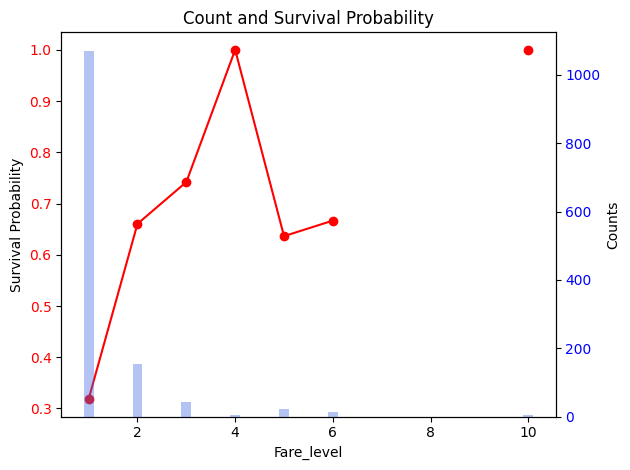

In [21]:
# Calculate the counts
variable = 'Fare_level'
counts = df[variable].value_counts()

# Calculate the probability of survival
survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
survival_prob = survived / (survived + not_survived)

# Create subplots with shared x-axis
fig, ax1 = plt.subplots()   

# Plot the survival probability using scatter plot markers and lines on the left y-axis
ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
ax1.set_ylabel('Survival Probability', color='black')
ax1.tick_params(axis='y', labelcolor='red')    

# Create a twin y-axis for the left side
ax2 = ax1.twinx()

#Plot the count bars on the right y-axis
ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
ax2.set_ylabel('Counts', color='black')
ax2.tick_params(axis='y', labelcolor='blue')

# Set the x-axis label and title
ax1.set_xlabel(variable)
plt.title('Count and Survival Probability')

# Adjust the layout of subplots
plt.tight_layout()

## 3.7 Cabin

This is the dirtiest column, most values are missing and some rows contain more than one value per column (more than one cabin for some passengers). The Cabin information can be very informative and the distance from the boat deck where the lifeboats were located may influence the chance of survival. But this column is not structured and has mostly missing values. To solve this, we can try to split this column into three columns: ["Cabin_label", "Cabin_number", "N_of_Cabins reserved"] and analyze these three columns together with the "Fare" values and the number of family members aboard, "FamilySize", in such a way that we can try to predict the missing values at least for the missing Cabin_label. We could apply a simple rule and estimate the missing Cabin_label by mapping the variable Fare or we could use a supervised simple algorithm like a decision tree to perform multiclassification of the Cabin_label based on the non-missing rows as a train set. Is not easy to establish criteria to fill NaN values and the volume of known data is too small compared to unknown data. I think the work to estimate the Cabin NaN values and create an engineered feature with this information is too hard and in the end, this variable can be discarded by the model due to inefficiency in predicting the survival probability or contain the same information already present in the variable "Pclass" and "Fare".

In [22]:
# Get the label of the last reserved cabin if exists
# get the last cabin if exists
df['Last_cabin'] = df['Cabin'].apply(lambda x: str(x).split()[-1] if pd.notnull(x) else 'N')

# get the Cabin_label of the last cabin
pattern = r'([A-Za-z])'
df['Cabin_label'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)).group(1) if x != 'N' else 'N')

# Get the number of the last cabin if exists
pattern = r'(\d+)'
df['Cabin_number'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)) if x != 'N' else -1)

# Get the number of distinct cabins reserved by the passenger.
df['Cabin_count'] = df['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# drop not used columns and columns with NaN values.
df.drop(columns = ['Cabin','Last_cabin', 'Cabin_number'], inplace = True)

## 3.8 Mapping Age

We will create the variable "Age_group". This new variable can be much more informative than the exact values of the "Age". We still have the problem of missing values. Here we use a decision tree to predict the missing values in the variable "Age_group".

**Women and children first!**

First of all, let us create the variable Age_group categorized with meaningful age ranges for each group until 60 years. The life expectancy in 1900 was around 50 years according to u.demog. Berkley. Here I chose the ranges 0–13 for kids, 13–30 for young, range 30–45 for a mature group, 45–60 for old. From 60 years we can classify as very old. This arbitrary categorization was chosen also to obtain a good prediction performance using decision trees. If we choose a smaller age range (with 10 years range, for example) the prediction accuracy reduces significative as the number of training data is small, and with fewer groups, we can provide more examples to train the tree for each class Age_group.

In [23]:
# Mapping Age
df.loc[df['Age'] <= 13, 'Age_group'] = 0 # kids
df.loc[(df['Age'] > 13) & (df['Age'] <= 30), 'Age_group'] = 1 # young
df.loc[(df['Age'] > 30) & (df['Age'] <= 45), 'Age_group'] = 2 # mature1
df.loc[(df['Age'] > 45) & (df['Age'] <= 60), 'Age_group'] = 3 # old
df.loc[(df['Age'] > 60) & (df['Age'] <= 100), 'Age_group'] = 4 # very old

# Calculate survival probability for each Age_group
age_survival_grouped = df.groupby('Age_group').agg({'Age': ['min', 'max'], 'Survived': ['mean', 'count']}).reset_index()
age_survival_grouped.columns = ['Age_group', 'Age_min' , 'Age_max', 'Survival_proba', 'Count']
age_survival_grouped

,Age_group,Age_min,Age_max,Survival_proba,Count
0,0.0,0.17,13.0,0.591549,71
1,1.0,14.00,30.0,0.366864,338
2,2.0,30.50,45.0,0.425743,202
3,3.0,45.50,60.0,0.407407,81
4,4.0,60.50,80.0,0.227273,22


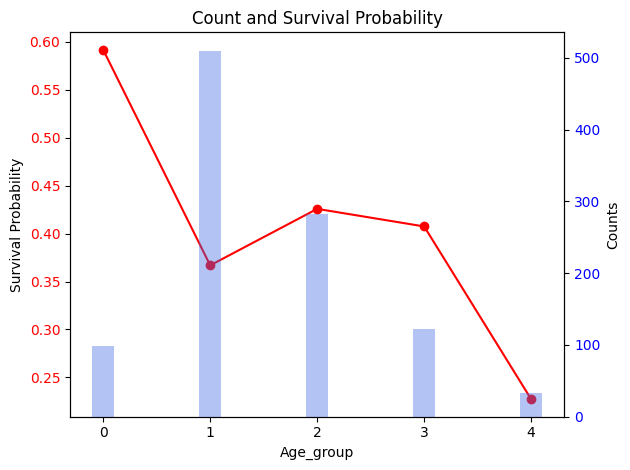

In [24]:
# Calculate the counts
variable = 'Age_group'
counts = df[variable].value_counts()

# Calculate the probability of survival
survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
survival_prob = survived / (survived + not_survived)

# Create subplots with shared x-axis
fig, ax1 = plt.subplots()   

# Plot the survival probability using scatter plot markers and lines on the left y-axis
ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
ax1.set_ylabel('Survival Probability', color='black')
ax1.tick_params(axis='y', labelcolor='red')    

# Create a twin y-axis for the left side
ax2 = ax1.twinx()

#Plot the count bars on the right y-axis
ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
ax2.set_ylabel('Counts', color='black')
ax2.tick_params(axis='y', labelcolor='blue')

# Set the x-axis label and title
ax1.set_xlabel(variable)
plt.title('Count and Survival Probability')

# Adjust the layout of subplots
plt.tight_layout()

## 3.9 Apply Decision Tree to fill NaN vaues in Age_group

We need to find a way to fill in the missing Age_group values. The passenger age value must be related to the other variables and I propose here we can predict the missing Age_group using the variables "Pclass", "Title", "Fare", "SibSp", and "Parch. We can understand that these variables are more related to age, for example, a passenger with a title = Master certainly will fit into the Age_group 0 (kids). Let us try to predict the Age_group using a decision tree multiclassification.

Since the variable "Title" doesn't has an inherent order it is better to apply one-hot encoding to this variable before inputting in the model.

In [25]:
encoded = pd.get_dummies(df['Title'], prefix='Title')
df = pd.concat([df, encoded], axis=1)
encoded.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_noble
0,False,False,True,False,False
1,False,False,False,True,False
2,False,True,False,False,False
3,False,False,False,True,False
4,False,False,True,False,False


In [26]:
# Load the data for training and validation the rows where Age is not NaN.
features = ['Pclass', 'SibSp', 'Parch','FamilySize', 'Fare', 'Sex_bool', 'Companions', 'Cabin_count',
            'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_noble']

X = df.loc[~df['Age'].isna(), features] 
Y = df.loc[~df['Age'].isna(), 'Age_group'] # the target variable we want o train for is Age_group

# Let us split the training set into train and valiication
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=22)

print('X_train.shape', X_train.shape)
print('Counts: ', Y_train.value_counts(dropna = False))

X_train.shape (732, 13)
Counts:  Age_group
1.0    360
2.0    192
3.0     89
0.0     67
4.0     24
Name: count, dtype: int64


In [27]:
#  Build a Decision Tree, to predict the Age_group.
from sklearn import tree
tree_age = tree.DecisionTreeClassifier(max_depth= 7,
                                       min_samples_leaf =10,
                                       # min_samples_split = 2,
                                       ccp_alpha = 0.002
                                      )
tree_age.fit(X_train, Y_train)
Y_pred = tree_age.predict(X_val)

# Calculate the train and Validation accuracy of the model.
train_acc = tree_age.score(X_train, Y_train)
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(Y_val, Y_pred)
print("train_Accuracy:", train_acc)
print("val_Accuracy:", val_acc)


train_Accuracy: 0.6338797814207651
val_Accuracy: 0.5923566878980892


We can plot the confusion matrix to analyze how the decision tree performs for each Age_group class.

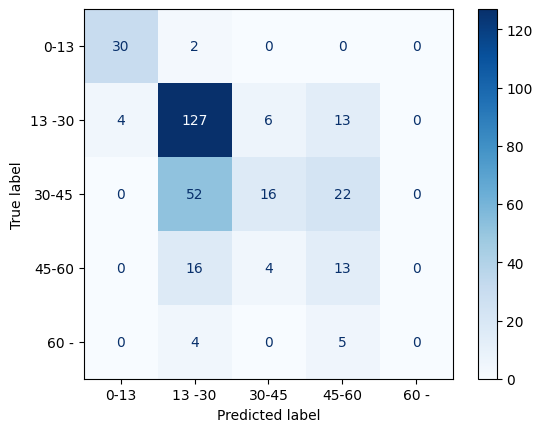

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['0-13', '13 -30', '30-45' , '45-60', '60 -']
# labels = tree_age.classes_
ConfusionMatrixDisplay.from_predictions(Y_val, Y_pred, display_labels = labels, cmap = plt.cm.Blues)
plt.show()

We can also plot the decision tree to visualize the nodes and leaves and the criteria for each node with the corresponding reduction probabilities.

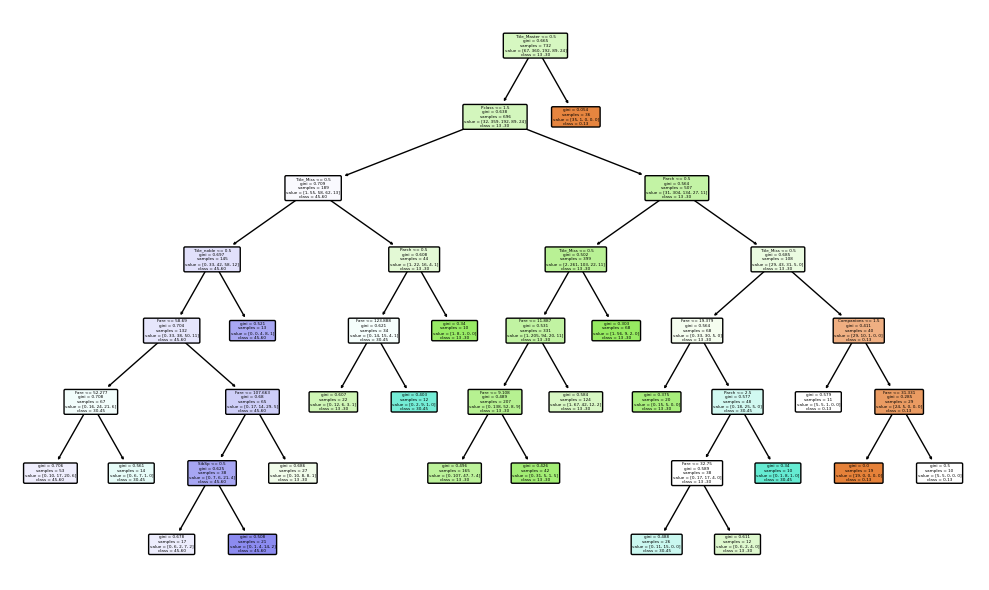

In [29]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(10, 6))
tree.plot_tree(tree_age, feature_names = features, class_names = labels, filled=True, rounded=True, ax=ax)
# Adjust the layout of subplots
plt.tight_layout()
# Display the plot
# plt.show()

# Save the figure with higher resolution
plt.savefig('Tree_age.png', dpi=600)

Use GridSearchCV process to make the hyperparameters tunning of the decision tree. We can try to optimize by pre-pruning with the parameters [max_depth, min_samples_leaf, min_samples_split], or we can tune using the post-pruning process with the cost complexity pruning this parameter ccp_alpha.

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [ 6 , 7 , 8, 9],    
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2 , 5, 10],
    'ccp_alpha': [0.002, 0.003, 0.004, 0.005]
}

# Create the decision tree classifier
model = tree.DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X, Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'ccp_alpha': 0.002, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Score: 0.5831768929288937


Finally, we will use the trained and optimized decision tree to fill in the missing Age_group values.

In [31]:
X_test = df.loc[df['Age_group'].isna(), features]
Age_group_pred = tree_age.predict(X_test)

# Fill the NaN values in Age_group
df.loc[df['Age_group'].isna(), 'Age_group'] = Age_group_pred

# drop not used columns and columns with NaN values.
df.drop(columns = ['Age'], inplace = True)

I finish here the dataset cleaning and feature engineering but I am sure that there is plenty of information hidden in the variable "Name", "Cabin" and "Ticket", and someone with more patience can dive into and explore.

In [32]:
print(df.columns)

# Check the variables with NaN values.
nan_counts = df.isna().sum().sort_values(ascending = False)
print('NaN in Train_data:\n', nan_counts)

# Expor the .csv file
df.to_csv('titanic_cleaned.csv', index = False)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_bool', 'Embarked_code',
       'Ticket_preffix', 'Ticket_number', 'Companions', 'FamilySize', 'Title',
       'noble', 'Fare_level', 'Fare_range', 'Cabin_label', 'Cabin_count',
       'Age_group', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_noble'],
      dtype='object')
NaN in Train_data:
 Survived          418
PassengerId         0
Title_Mrs           0
Title_Mr            0
Title_Miss          0
Title_Master        0
Age_group           0
Cabin_count         0
Cabin_label         0
Fare_range          0
Fare_level          0
noble               0
Title               0
FamilySize          0
Companions          0
Ticket_number       0
Ticket_preffix      0
Embarked_code       0
Sex_bool            0
Embarked            0
Fare                0
Ticket              0
Parch               0
SibSp               0
Sex                 0
Name          

--------------------------------------

# 4. Exploratory analysis

We can make some exploratory analysis with the newly cleaned and feature-engineered Titanic dataset.

In [33]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_bool', 'Embarked_code',
       'Ticket_preffix', 'Ticket_number', 'Companions', 'FamilySize', 'Title',
       'noble', 'Fare_level', 'Fare_range', 'Cabin_label', 'Cabin_count',
       'Age_group', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_noble'],
      dtype='object')


In [34]:
def plot_countplot(variable='Sex'):
    # Calculate the counts
    counts = df[variable].value_counts()
    
    # Calculate the probability of survival
    survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
    not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
    survival_prob = survived / (survived + not_survived)

    # Create subplots with shared x-axis
    fig, ax1 = plt.subplots()   
    
    # Plot the survival probability using scatter plot markers and lines on the left y-axis
    ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
    ax1.set_ylabel('Survival Probability', color='black')
    ax1.tick_params(axis='y', labelcolor='red')    
    
    # Create a twin y-axis for the left side
    ax2 = ax1.twinx()
    
    #Plot the count bars on the right y-axis
    ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
    ax2.set_ylabel('Counts', color='black')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Set the x-axis label and title
    ax1.set_xlabel(variable)
    plt.title('Count and Survival Probability')
    
    # Adjust the layout of subplots
    plt.tight_layout()

# Call the interact function
interact(plot_countplot, variable=df.columns)

interactive(children=(Dropdown(description='variable', index=4, options=('PassengerId', 'Survived', 'Pclass', …

<function __main__.plot_countplot(variable='Sex')>

 Same plot but using plotly

In [35]:
def plot_Var_Survival_Volume(variable='Pclass'):
    # Calculate the counts
    counts = df[variable].value_counts()
    
    # Calculate the probability of survival
    survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
    not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
    survival_prob = survived / (survived + not_survived)

    # Create subplots with shared x-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])   
    
    # Add a scatter trace for survival probability
    fig.add_trace(go.Scatter(x=survival_prob.index, y=survival_prob.values, mode='markers+lines', name='Survival Probability', marker_color='red'), secondary_y = False)
    # Add a bar trace for counts
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, name='Counts',width = 0.4, opacity=0.4, marker_color='royalblue'), secondary_y = True)
    
    # Set leayout 
    fig.update_layout(title='Count and Survival Probability',
                      height = 600,
                      width = 900,
                      font=dict(
                            family="Sans serif",
                            size=20,
                        ),
                      xaxis = dict(
                          showline=True, linewidth=2, linecolor = 'black', mirror=True,
                          showgrid=False, ticks='outside',
                      ),
                      yaxis = dict(
                          title_text="Survival Probability",
                          showline=True, linewidth=2, linecolor = 'black', mirror=True,
                          showgrid=False,
                          ticks='outside',
                          tickfont=dict(color='red')
                      ),
                      yaxis2 = dict(
                          title_text="Counts",
                          ticks='outside',
                          tickfont=dict(color='blue')
                      )
    )  


    # Show the plot
    fig.show()

# Call the interact function
interact(plot_Var_Survival_Volume, variable=df.columns)




interactive(children=(Dropdown(description='variable', index=2, options=('PassengerId', 'Survived', 'Pclass', …

<function __main__.plot_Var_Survival_Volume(variable='Pclass')>

Same plot using Dash app.py in workdir...

## Dash app - Titanic Survival probabilities - variables
[Titanic-Survival Probability for Variables](https://titanic-survivalprobability-variables.onrender.com)

Let us check the correlations between the variables of the dataset.

<Axes: >

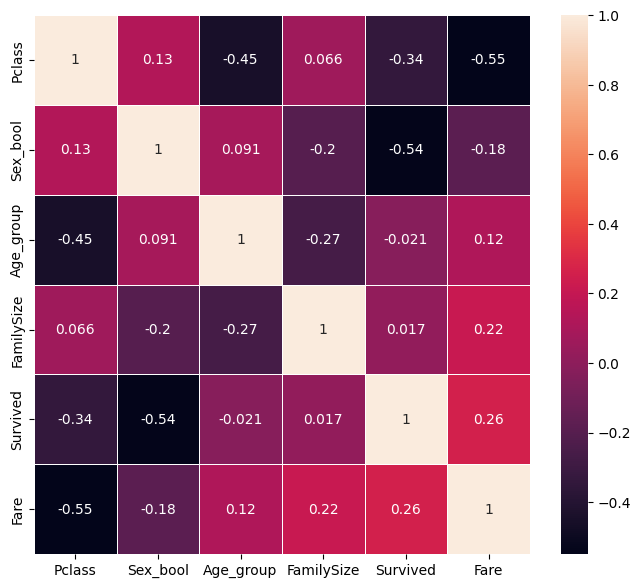

In [36]:
# print(train_data.corr())
corrMatrix = df[train_idx].loc[:, ['Pclass', 'Sex_bool', 'Age_group', 'FamilySize', 'Survived', 'Fare']].corr()
fig, ax = plt.subplots(figsize=(8,7))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

## 4.1 Passengers with missing Cabin info

What is the profile of the passengers that has no Cabin information, or Cabin_label = N. Analyzing the distributions of the features of the passengers that were in each cabin label, we can see that the profile of the passengers with missing Cabin info is very close to the profile of all passengers, regardless of which the Cabin they were located. It can be understood as the passengers within the group with Cabin_label = N were not mostly from the lowest class social status (Pclass = 3). There are passengers from the three Pclass values with missing Cabin values. The missing cabin info is not related to a given Pclass, Sex, or Age_group, it is randomly distributed. That is why it is very hard to use this feature, with this structure, in a meaningful way.

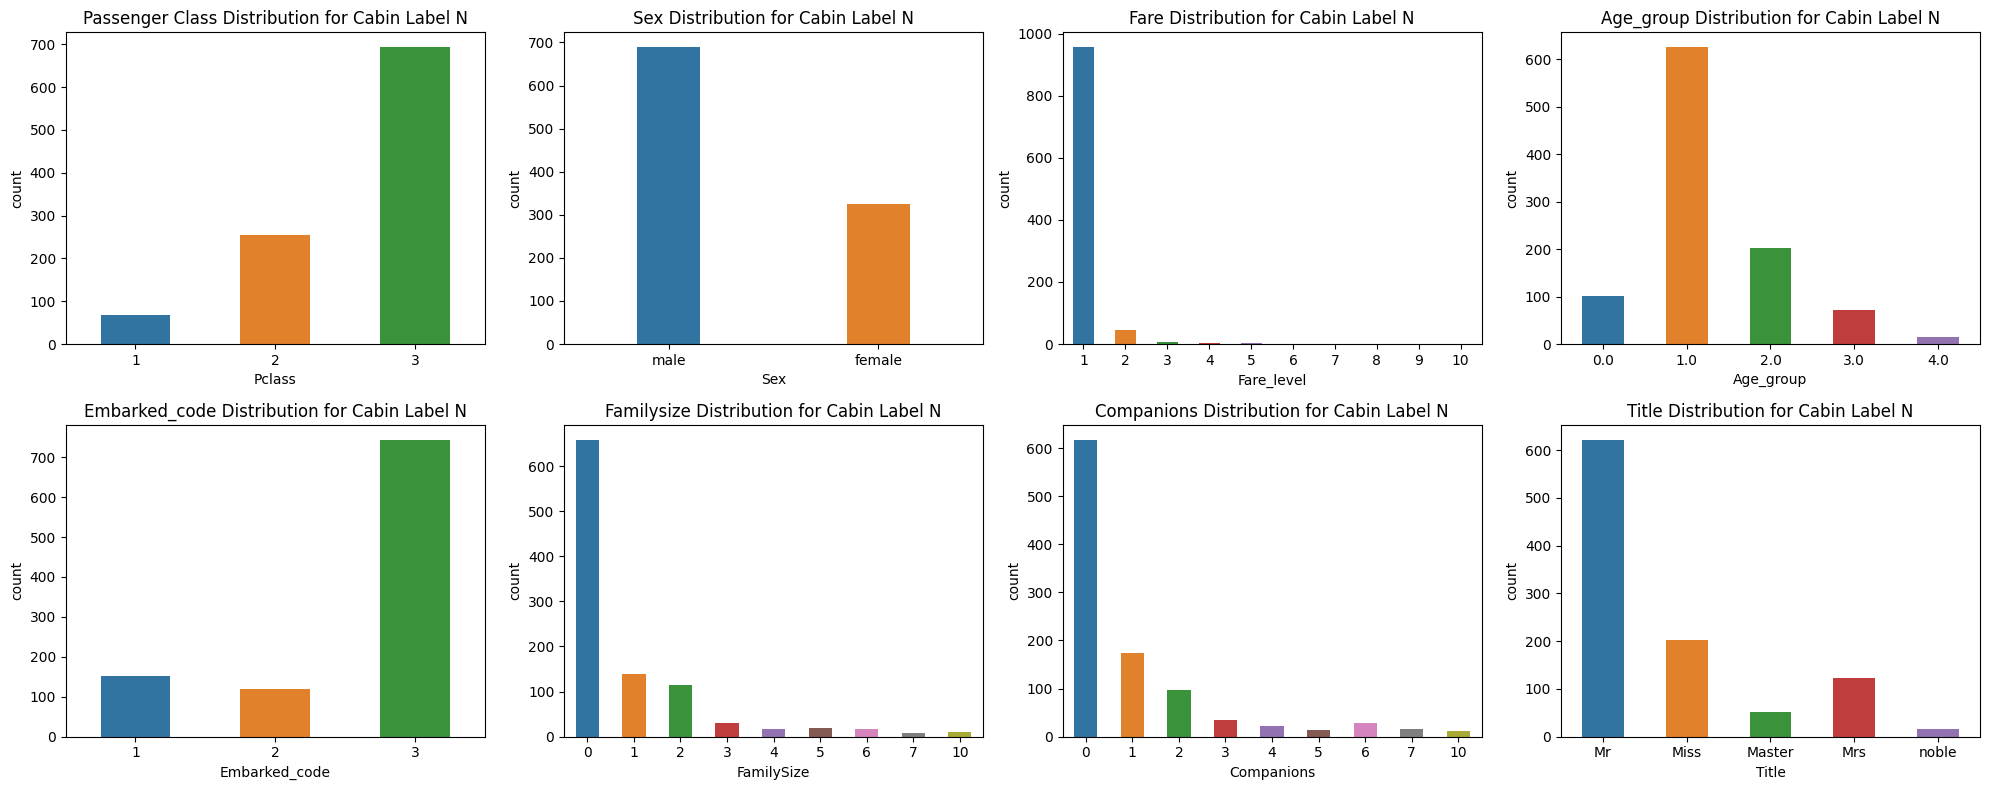

In [37]:
# Filter the DataFrame for passengers with cabin label 'N'
cabin_N_passengers = df[df['Cabin_label'] == 'N']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Plot the distribution of classes
sns.countplot(x='Pclass', data=cabin_N_passengers, ax=axes[0,0], width=0.5)
axes[0,0].set_title('Passenger Class Distribution for Cabin Label N')

# Plot the distribution of sex
sns.countplot(x='Sex', data=cabin_N_passengers, ax=axes[0,1], width=0.3)
axes[0,1].set_title('Sex Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Fare_level', data=cabin_N_passengers, ax=axes[0,2], width=0.5)
axes[0,2].set_title('Fare Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Age_group', data=cabin_N_passengers, ax=axes[0,3], width=0.5)
axes[0,3].set_title('Age_group Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Embarked_code', data=cabin_N_passengers, ax=axes[1,0], width=0.5)
axes[1,0].set_title('Embarked_code Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='FamilySize', data=cabin_N_passengers, ax=axes[1,1], width=0.5)
axes[1,1].set_title('Familysize Distribution for Cabin Label N')
# Plot the distribution of fare
sns.countplot(x='Companions', data=cabin_N_passengers, ax=axes[1,2], width=0.5)
axes[1,2].set_title('Companions Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Title', data=cabin_N_passengers, ax=axes[1,3], width=0.5)
axes[1,3].set_title('Title Distribution for Cabin Label N')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

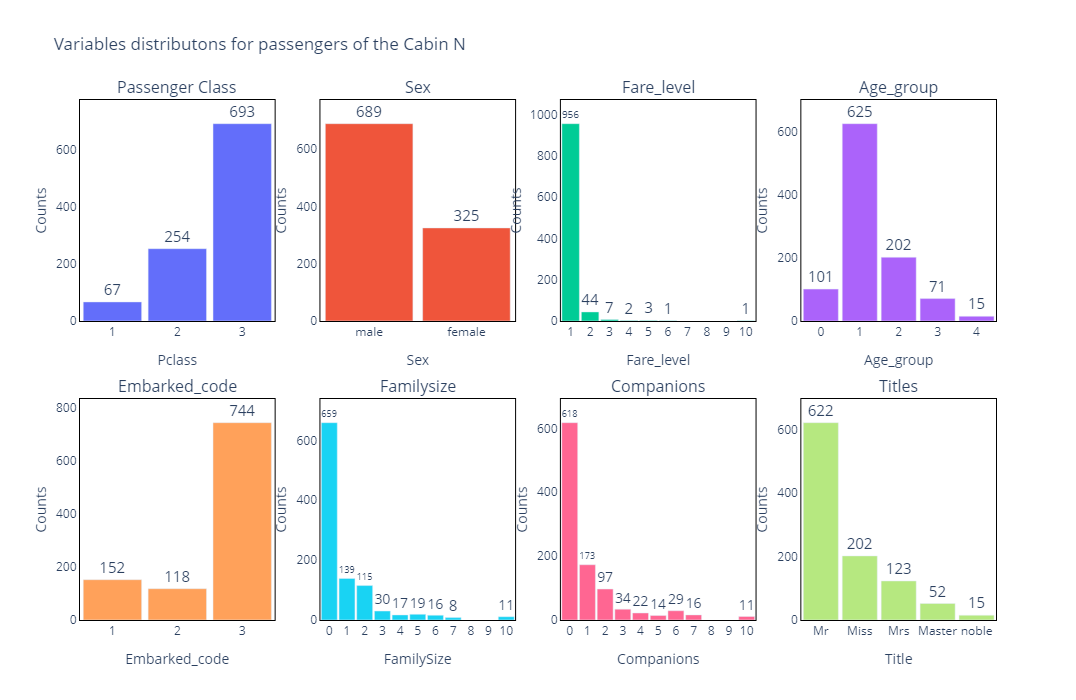

In [38]:
# Load the dataset
myTitanic_dataset = 'https://raw.githubusercontent.com/praoiticica/Titanic-traditional-ML/main/titanic_datasets/titanic_cleaned.csv'
df = pd.read_csv(myTitanic_dataset)
# Filter the DataFrame for passengers with cabin label 'N'
cabin_N_passengers = df[df['Cabin_label'] == 'N']

# Create subplots
fig = make_subplots(rows=2, cols=4,
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05,
                    subplot_titles=[
                            'Passenger Class',
                            'Sex',
                            'Fare_level',
                            'Age_group',
                            'Embarked_code',
                            'Familysize',
                            'Companions',
                            'Titles'
                            ]
                   )

# Define the column names and subplot indices
column_names = ['Pclass', 'Sex', 'Fare_level', 'Age_group', 'Embarked_code', 'FamilySize', 'Companions', 'Title']
subplot_indices = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4)]

# Add traces for each column
for i, column in enumerate(column_names):
    row, col = subplot_indices[i]
    counts = cabin_N_passengers[column].value_counts()
    max_count = counts.max()
    
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, text = counts.values, textposition='outside', width = 0.9), row=row, col=col)
    
    # Update x-axis and y-axis titles
    fig.update_xaxes(title=column, row=row, col=col)
    fig.update_yaxes(title='Counts', row=row, col=col, title_standoff=0.1)
    fig.update_traces(textfont={'size': 15}, row=row, col=col)
    
     # Calculate the y-axis range with a small margin
    y_range = [0, max_count * 1.12]  # Adjust the margin as desired
    fig.update_yaxes(range=y_range, row=row, col=col)


# Update subplot size and spacing
fig.update_layout(
    title = 'Variables distributons for passengers of the Cabin N',
    height=700, width=1500, showlegend=False,
    plot_bgcolor='white', paper_bgcolor='white',
)

# Set x-axis tickmode to 'linear' and dtick to 1 to show all tick values
fig.update_xaxes(tickmode='linear', dtick=1)

# Update subplot axis options
for row in range(1, 3):
    for col in range(1, 5):
        fig.update_xaxes(showline=True, mirror=True, linecolor='black', row=row, col=col)
        fig.update_yaxes(showline=True, mirror=True, linecolor='black', row=row, col=col)

fig.show()

## Dash app to interact and see the results for each cabin label

## Dash plot - Titanic_Cabin Label profiles

['Variables distributons for passengers of the Cabin labels'](https://titanic-eda-cabinlabel-barplots.onrender.com/)

----------------------

# 5. Titanic Survival classification with Decision Tree

In the cleaned and engineered dataset, there are parts for testing. This has the variable "survived" with missing NaN values. We will build, train and validate the decision tree with the training part of the dataset and apply the tree to predict the "Survived" values in the test data 

In [39]:
Test_data = df.loc[df['Survived'].isna()]
Train_data = df.loc[~df['Survived'].isna()]

Train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_bool', 'Embarked_code',
       'Ticket_preffix', 'Ticket_number', 'Companions', 'FamilySize', 'Title',
       'noble', 'Fare_level', 'Fare_range', 'Cabin_label', 'Cabin_count',
       'Age_group', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_noble'],
      dtype='object')

In [40]:
# Load the data for training and validation
features = ['Pclass','Sex_bool', 'SibSp', 'Parch', 'Companions', 'FamilySize', 'Fare_level', 'Cabin_count', 'Age_group', 'Title_noble']

X = Train_data[features] # training dataset
Y = Train_data['Survived']

# Let us split the training set into train and valiication
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.30, random_state=42)

#  Build a decision Tree, train and validate the model.
from sklearn import tree
modeltree = tree.DecisionTreeClassifier(criterion='gini',
                                        max_depth= 5, # 5, 5, None,
                                        min_samples_leaf = 2, # 5, None, 
                                        min_samples_split = 2, # 2, 5, 2
                                        ccp_alpha = 0.00306  # 0, 0.002, 0.00307, 

                                        )
modeltree.fit(X, Y)
Y_pred = modeltree.predict(X_val)

# Calculate the train and Validation accuracy metric.
train_acc = modeltree.score(X_train, Y_train)
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(Y_val, Y_pred)
print("train_Accuracy:", train_acc)
print("val_Accuracy:", val_acc)

train_Accuracy: 0.8346709470304976
val_Accuracy: 0.835820895522388


## 5.1 Visualization of the Titanic survival Decision tree

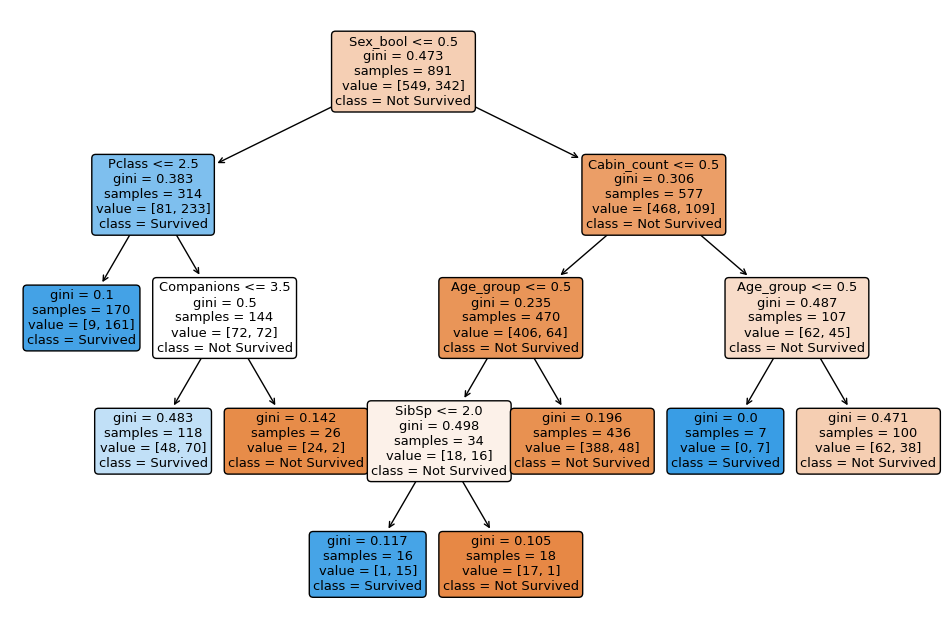

In [41]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(12, 8))
tree_plot = tree.plot_tree(modeltree, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, ax=ax)
# plt.show() # Comment it to make savefig() works.
# Save the figure with higher resolution
plt.savefig('titanic-Tree1.png', dpi=300)

## 5.2 Hyperparameter tunning - pre-pruning with GridSeachCV

We can use GridSeachCV (from scikit-learn) to exhaustive search over specific parameters and find the best combination of hyperparameters that yield the maximum metric score (accuracy in this case). In the case of decision trees, we can search for the best set of max_depth, min_samples_leaf, and min_samples_split.


In [42]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [4, 5, 6],    
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
#     'ccp_alpha': ccp_alphas
}

# Create the decision tree classifier
clf = tree.DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10)
grid_search.fit(X, Y) # k-Fold CrossValidation in entire Train_data

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.8360923845193508


## 5.3 Hyperparameter tunning - Cost-complexity pruning (weak links pruning)

The cost complexity pruning method consists of tuning the parameter aplha (ccp_alpha). This parameter stablishes a subtree for which the cost complexity measure is minimum. Let us explain it slowly. When we train a decision tree with the default parameters, or sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0) (see [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)), the tree growths until the impurity measure reach the minimum possible value and there is no other possibility to split the nodes with a given feature to reduce the Gini impurity of the nodes. Here we can represent the impurity measure of the tree by R(T). in scikit-learn it is given by the total sample weighted impurity of the terminal node of the tree. This is the full-sized tree and it is the best tree to fit the training data but it does not perform well with validation data (It is overfitting the training data). We need a criterion to stop the natural tree growth in a given growth step so it still fits good the train data and also the validation data. During the training of the tree each growth step creates a new split in a given node to reduce the Gini impurity of the terminal nodes of the tree so It is a good strategy to prune the full sized tree following the reverse path of the growth so we recursively decrease tree terminal nodes impurity until we obtain a tree that don’t overfits.

To easily adjust the point until which we will recursively prune the tree we define a penalty function given by a constant $\alpha$ times the number of terminal nodes |T| (penalty function =  $\alpha$|T|). Then we define the cost complexity measure of the tree T, $R_\alpha(T)$ as:

$$R_\alpha(T) = R(T) + \alpha|T|$$
When $\alpha$ is zero the complexity measure of the full sized tree $T_n$ and all previous states of the model during the training (the subtrees $T_i$ ) are given by the weighted impurity of the terminal nodes of the subtree and discussed above it has a minimum at the last growth state subtree ($T_n$), the full sized tree. When we set $\alpha$ a given value the cost complexity function will have a minimum for a subtree $T_i$ in a previous growth state. That is because the penalty function increases more the cost complexity measure $R_\alpha(T)$ for subtrees with greater number of terminal nodes. If we scan the $\alpha$ parameter from zero to slowly increasing positive values the full sized tree $T_n$ will have progressively higher values of cost complexity $R_\alpha(T_n)$ until a given point that the subtree $T_{n-1}$ will corresponds to the minimum cost complexity measure, $R_\alpha(T_{n-1}) < R_\alpha(T_n)$, this ccp_alpha value corresponds to the post-prune until the subtree $T_{n-1}$. Let us visualize it in the below plot where we represent the impurity values R(T) as an exponential decay function that decreases with the tree growth step. Adding a linear penalty function results in a cost complexity function $R_\alpha(T)$ that has a minimum at the growth step i where $R(T_i) = \alpha T_i$.

References:
1. Scikit-learn, "Cost complexity pruning", [scikit-learn - cpp_alpha pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)
2. See this video very informative [SatQuest - How to prune repression trees](https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=44).
3. L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.
984.)
)

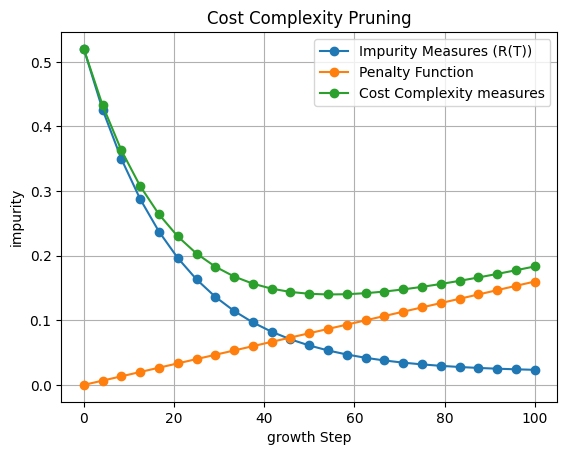

In [43]:
alpha = 0.002  # arbitrary choosen value for alpha
growth_step = np.linspace(0, 100, 25)  # Array of growth steps
impurity_values = 0.5 * np.exp(-growth_step / 20) + 0.02  # Example impurity values (exponential decay)
n_terminal_nodes = growth_step * 2 - growth_step * 1.2 # suppouse numbe rof terminal nodes increase in this way.
penalty_values = alpha * n_terminal_nodes
ccp_fn = impurity_values + penalty_values
# Plot the traces
plt.plot(growth_step, impurity_values, marker='o', label='Impurity Measures (R(T))')
plt.plot(growth_step, penalty_values, marker='o', label='Penalty Function')
plt.plot(growth_step, ccp_fn, marker='o', label='Cost Complexity measures')
plt.xlabel('growth Step')
plt.ylabel('impurity')
plt.title('Cost Complexity Pruning')
plt.legend()
plt.grid(True)
plt.show()

## 5.4 Cost complexity pruning steps (weak link pruning)

To perform cost complexity pruning and determine the optimal ccp_alpha value process as follows:
1. Build a full-sized tree (ccp_alpha = 0) and train it with the entire available dataset. then use the method scikit-learn cost_complexity_pruning_path to compute the pruning path during minimal cost-complexity pruning. It returns the lists for effective alphas and the corresponding total leaf impurities of the full-sized tree. The values in the lists correspond to each subtree after successive pruning steps.

2. For each alpha obtained in step 2, we will build a classifier and append it to a list. The performance of the classifiers will be compared in a Cross-Validation process to determine the tree and the corresponding ccp_alpha that is appropriate for the actual problem and available data (employed features, training data) not overfitting nor underfitting the training data.

3. Plot the cross-validation train_scores and the validation_scores for each ccp_apha value. When the ccp_alpha decreases from the maximum value (corresponding to a tree with only one node) the train and validation scores tend to increase until a given point where the validation score reaches a maximum and stops increasing while the training score keeps increasing as a result of the model overfitting the training data. It is intuitive the choice the optimal ccp_alpha in a point where the tree is not overfitting not underfitting the training data while yielding a good performance on validation and test data.

4. Finally built a final tree and train it using the entire dataset and the chosen optimal ccp_alpha value.

In [44]:
# Build and train a full sized tree with entire data
fulltree = tree.DecisionTreeClassifier(ccp_alpha = 0, random_state=22) # 'Full sized tree' trained with entire data
fulltree.fit(X, Y)
# Compute ccp_alpha and Gini imputrities values for each subtree.
path = fulltree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Create a DataFrame to store the cost complexity pruning values.
ccp_df = pd.DataFrame({'ccp_alphas': ccp_alphas, 'impurities': impurities})

cv_results = {}
# Cross-Validation for the set of subtrees and export results to a table.
from sklearn.model_selection import KFold
KF = KFold(n_splits=10, shuffle=False, random_state=None)
for i, (train, val) in enumerate(KF.split(X, Y)):
    X_train = X.iloc[train]
    Y_train = Y.iloc[train]
    X_val = X.iloc[val]
    Y_val = Y.iloc[val]
    # build a classifier for each alpha and append to a list.
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_train, Y_train)
        clfs.append(clf)

    train_scores = [accuracy_score(Y_train, clf.predict(X_train) ) for clf in clfs]
    val_scores = [accuracy_score(Y_val, clf.predict(X_val) ) for clf in clfs ]

    cv_results[f'split{i}_train_scores'] = train_scores
    cv_results[f'split{i}_val_scores'] = val_scores


# contatenate the cross-validation results to the ccp_df
ccp_df = pd.concat([ccp_df, pd.DataFrame(cv_results)], axis=1)

# calculate the cross-validation mean for train_scores and val_scores
train_score_cols = [f'split{i}_train_scores' for i in range(0, 10)]
val_score_cols = [f'split{i}_val_scores' for i in range(0, 10)]
ccp_df['train_scores'] = ccp_df[train_score_cols].mean(axis=1)
ccp_df['val_scores'] = ccp_df[val_score_cols].mean(axis=1)

ccp_df[['ccp_alphas', 'train_scores', 'val_scores' ]].head()

,ccp_alphas,train_scores,val_scores
0,0.000000,0.885397,0.803633
1,0.000000,0.885397,0.803633
2,0.000000,0.885397,0.803633
3,0.000001,0.885397,0.803633
4,0.000035,0.885397,0.803633


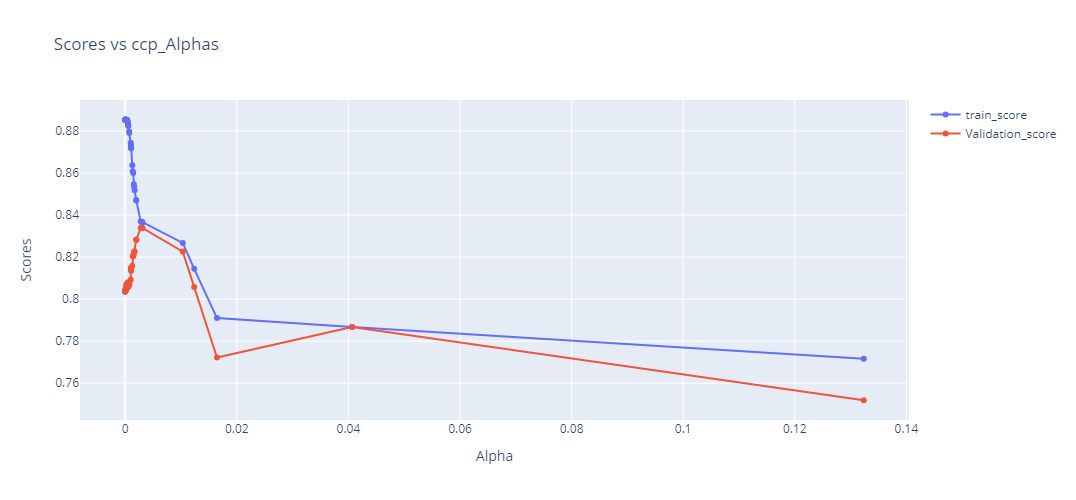

In [45]:
# Create scatter plot for train and validation scores
fig = go.Figure()

fig.add_trace(go.Scatter(x=ccp_df['ccp_alphas'], y=ccp_df['train_scores'], mode='lines+markers', name='train_score'))

# Create scatter plot for training scores
fig.add_trace(go.Scatter(x=ccp_df['ccp_alphas'], y=ccp_df['val_scores'], mode='lines+markers', name='Validation_score'))


# Set plot layout
fig.update_layout(title='Scores vs ccp_Alphas',
                  height=500,
                  width=800,
                  xaxis_title='Alpha',
                  yaxis_title='Scores')

fig.show()

In [48]:
# # Upload the plot to Chart Studio
# chart_studio_plot = py.plot(fig, auto_open=False, filename='ccp_aplha_TrainVal scores')

## 5.5 The Final optimized decision tree

In [49]:
# Load the data for training and validation
features = ['Pclass','Sex_bool', 'SibSp', 'Parch', 'Companions', 'FamilySize', 'Fare_level', 'Cabin_count', 'Age_group', 'Title_noble']

X = Train_data[features] # training dataset
Y = Train_data['Survived']


from sklearn import tree
finaltree = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha = 0.00306) # I choosed the optimal ccp_alpha  = 0.003062
finaltree.fit(X, Y) #  Build the final decision Tree with the entire training dataset.
train_acc = finaltree.score(X, Y)
print("Final tree train_Accuracy:", train_acc)

Final tree train_Accuracy: 0.835016835016835


Now we can apply the final tree to predict the variable "Survived" in the test_data and export a submission.csv

In [50]:
# The test_data all values of "Survived" are NaN.
X_test = Test_data[features]

# make a prediction of the "Survived" in the test dataset.
Y_pred = finaltree.predict(X_test)

# Export results to .csv
Y_pred = np.round(Y_pred).astype(int)
passengerId = Test_data['PassengerId']
output = pd.DataFrame({'PassengerId': passengerId, 'Survived': Y_pred})
output.to_csv('DecisionTree_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Let us check the structure of the final Titanic survival decision tree.

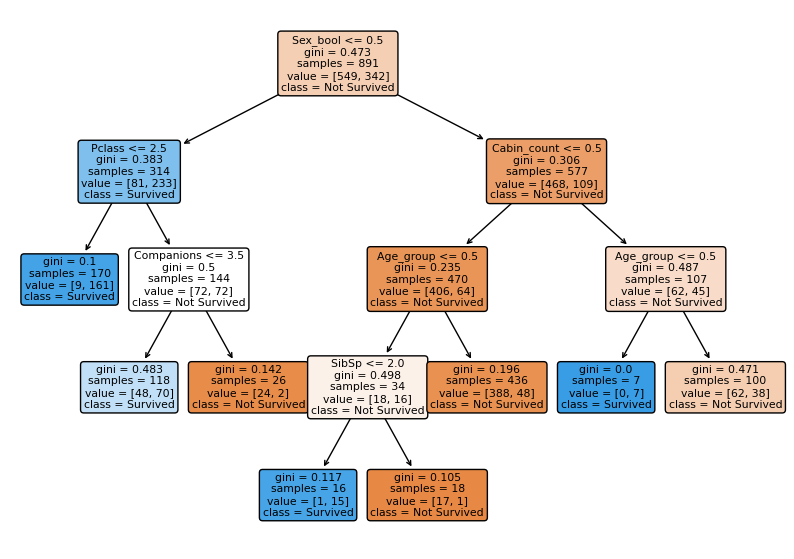

In [51]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(10, 7))
tree_plot = tree.plot_tree(finaltree, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, ax=ax)
# plt.show() # Comment it to make savefig() works.
# Save the figure with higher resolution
plt.savefig('titanic-FinalTree.png', dpi=300)

plot the confusion matrix

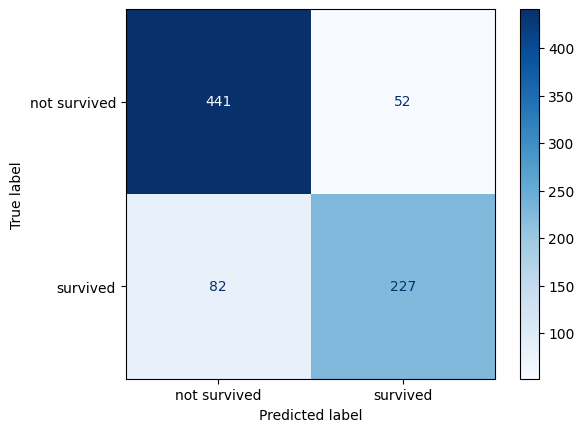

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['not survived', 'survived']
# labels = tree_age.classes_
ConfusionMatrixDisplay.from_predictions(Y_train, finaltree.predict(X_train), display_labels = labels, cmap = plt.cm.Blues)
plt.show()

# 6. Conclusion

We end up with a decision tree that can be used to decide who lives and who dies on the Titanic. The accuracy of the optimized tree is approximately 83% for the training data. Analyzing the confusion matrix, we can see our final tree killed 52 passengers out of 227 that really survived and predated that 82 survived among the 441 that unfortunately not survived the tragedy. That is the performance of our optimized decision tree. The Decisions tree is named a weak or simple classifier we can not expect too much from this algorithm as it is based on simple criteria rules for decisions and it overfits easily if we let the algorithm leans without pruning or limiting the growth.  Although it is very light and simple such that we can build an ensemble model based on a set of trees, Random Forest.